In [7]:
import pandas as pd
import numpy as np
import datetime
import time

**train_mfti.parquet** – сырые данные, которые можно использовать для обучения модели

* event_date – дата взаимодейтсвия
* event_timestamp – timestamp взаимодействия в секундах 
* vacancy_id_ - id вакансии, с которой было взаимодействие
* cookie_id – id пользователя по его браузеру/ip/устройству
* user_id – id пользователя на сайте rabota.ru (есть только для зарегистрированных пользователей)
* event_type – тип взаимодействия

In [23]:
# Загружаем датасет
data_folder = 'Data_Rabota'
df = pd.read_parquet(f"{data_folder}/Processed_dataset.parquet")

In [24]:
df.head()

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type
0,1,2022-08-30,1661866548,0.0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy
1,1,2022-08-30,1661866548,11.0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy
2,1,2022-08-30,1661866559,0.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy
3,1,2022-08-30,1661866559,5.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy
4,1,2022-08-30,1661866564,0.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy


In [64]:
nonrel_vac_list = ['show_vacancy',
                'preview_click_vacancy',
                'click_favorite',
                'preview_click_favorite']

rel_vac_list = ['click_response',
                'preview_click_response',
                'click_contacts',
                'preview_click_contacts',
                'click_phone',
                'preview_click_phone']
df['shifted_event_type'] = df['event_type'].shift(-1)


def get_number_relevant_vac(x, purpose_vac):    
    if x == purpose_vac and x.shift(-1) in rel_vac_list:
        return 1
    else:
        return 0

for nonrel_vac in nonrel_vac_list:
    df[nonrel_vac] = np.where((df['event_type'] == nonrel_vac) & df['shifted_event_type'].isin(rel_vac_list), 1, 0)
df = df.drop(columns=['shifted_event_type'])
df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,show_vacancy,preview_click_vacancy,click_favorite,preview_click_favorite
0,1,2022-08-30,1661866548,0.0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0,0,0,0
1,1,2022-08-30,1661866548,11.0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,0,0,0
2,1,2022-08-30,1661866559,0.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,0,0,0
3,1,2022-08-30,1661866559,5.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0,0,0,0
4,1,2022-08-30,1661866564,0.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12292583,367641,2022-08-22,1661164755,0.0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0,1,0,0
12292584,367641,2022-08-22,1661164755,791.0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_contacts,0,0,0,0
12292585,367641,2022-08-22,1661165546,1.0,185412,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0,0,0,0
12292586,367641,2022-08-22,1661165547,5.0,185412,ffffdb17f45b4032b386d691d52e6c00,None,show_vacancy,1,0,0,0


In [65]:
res_dict = {}
for nonrel_vac in nonrel_vac_list:
    current_vac_dict = {}
    current_vac_dict['counter'] = df[nonrel_vac].sum()
    current_vac_dict['sum'] = len(df[df['event_type']==nonrel_vac])
    current_vac_dict['perc'] = df[nonrel_vac].sum() / len(df[df['event_type']==nonrel_vac]) * 100.0
    res_dict[nonrel_vac] = current_vac_dict
action_analysis_df = pd.DataFrame.from_dict(res_dict, orient='index')
action_analysis_df

,counter,sum,perc
show_vacancy,425338,6198889,6.861520
preview_click_vacancy,265749,4781280,5.558114
click_favorite,11512,155844,7.386874
preview_click_favorite,5166,107016,4.827316


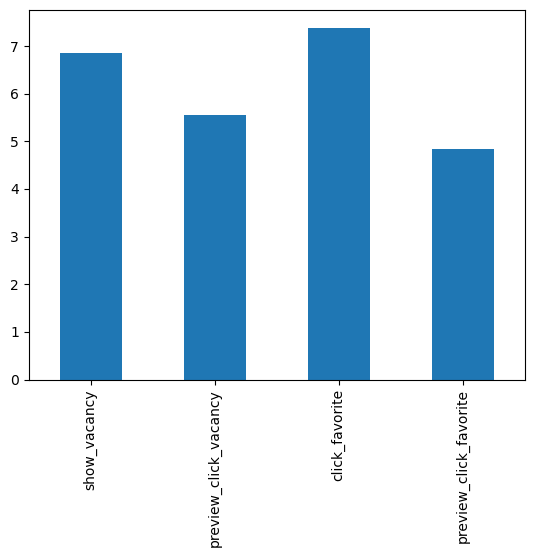

In [66]:
action_analysis_df['perc'].plot.bar();

In [71]:
df['nonrel_action_time'] = np.where(df['event_type'].isin(nonrel_vac_list), df['action_time'], 0)
df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,show_vacancy,preview_click_vacancy,click_favorite,preview_click_favorite,nonrel_action_time
0,1,2022-08-30,1661866548,0.0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0,0,0,0,0.0
1,1,2022-08-30,1661866548,11.0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,0,0,0,11.0
2,1,2022-08-30,1661866559,0.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,0,0,0,0.0
3,1,2022-08-30,1661866559,5.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0,0,0,0,5.0
4,1,2022-08-30,1661866564,0.0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12292583,367641,2022-08-22,1661164755,0.0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0,1,0,0,0.0
12292584,367641,2022-08-22,1661164755,791.0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_contacts,0,0,0,0,0.0
12292585,367641,2022-08-22,1661165546,1.0,185412,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0,0,0,0,1.0
12292586,367641,2022-08-22,1661165547,5.0,185412,ffffdb17f45b4032b386d691d52e6c00,None,show_vacancy,1,0,0,0,5.0


In [73]:
df.groupby(['common_id', 'vacancy_id_'])['nonrel_action_time'].sum()

common_id  vacancy_id_
1          137659            18.0
           153975            11.0
           174953            48.0
           176171             6.0
           182445            18.0
                           ...   
367641     107125         10105.0
           107893             0.0
           150843             0.0
           160164             0.0
           185412             6.0
Name: nonrel_action_time, Length: 4723189, dtype: float64

In [ ]:
# Выводим информацию о количестве событий каждого типа

train_mfti_df_up['event_type'].value_counts()

In [ ]:
# Выводим информацию о количестве уникальных значений для всех колонок

print(f"nUnique vacancy_id_: {train_mfti_df['vacancy_id_'].nunique()}")
print(f"nUnique event_date: {train_mfti_df['event_date'].nunique()}")
print(f"nUnique cookie_id: {train_mfti_df['cookie_id'].nunique()}")
print(f"nUnique user_id: {train_mfti_df['user_id'].nunique()}")
print(f"nUnique user_id: {train_mfti_df['user_id'].nunique()}")

In [ ]:
# Проверяем, всегда ли одному cookie_id соответствует один user_id.
# НЕТ

train_mfti_df.groupby(['cookie_id'])['user_id'].nunique().value_counts()

In [ ]:
# Проверяем, всегда ли одному cookie_id соответствует один common_id.
# НЕТ

train_mfti_df.groupby(['cookie_id'])['common_id'].nunique().value_counts()

In [ ]:
# Проверяем, всегда ли одному user_id соответствует один cookie_id.
# НЕТ

train_mfti_df.groupby(['user_id'])['cookie_id'].nunique().value_counts()

In [ ]:
# Проверяем, всегда ли одному common_id соответствует один cookie_id.
# НЕТ

train_mfti_df.groupby(['user_id'])['cookie_id'].nunique().value_counts()

**test_public_mfti.parquet** – часть теста, с открытым таргетом, для проверки работоспособности решений.

* cookie_id - id пользователя по его браузеру/ip/устройству
* vacancy_id_ - список вакансий, на которые пользователь откликнулся или позвонил в течение месяца после окончания данных train

In [64]:
test_public_mfti_df = pd.read_parquet('Data_Rabota/test_public_mfti.parquet', engine='pyarrow')
test_public_mfti_df

,cookie_id,vacancy_id_
0,000cd76cd33f43d4a1ac1d16d10f8bf7,"[222177, 222173, 222163, 238874, 238878, 22812..."
1,0034bc7f404341ba8412665453e7825a,"[102794, 137587, 257319, 237756, 240744, 11348..."
2,00a6c5a64a274c55a836402bdeb3b2c4,"[254292, 164602, 116438, 228634, 218819, 24065..."
3,015937a125b14e74bdff1cddc49f9172,"[246685, 138123, 115420, 210628, 212325, 235196]"
4,01de50c280794cec8804f16f45f847b7,"[219070, 251469, 166899, 212703, 214561]"
...,...,...
767,fdbcda17f22f406486837059e76c7fed,"[207851, 254989, 213344, 214180, 222146]"
768,fe6193ab26494ace9be5aae36e507618,"[115352, 230546, 225527, 120188, 109360, 23212..."
769,fe95b2826ee1452b81201ed3f4c3294d,"[240362, 114852, 253946, 251081, 127546, 244688]"
770,ff1aef256a49481698bb2e938510ff36,"[231194, 236363, 220747, 244688, 100094, 24052..."


In [65]:
test_public_mfti_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cookie_id    772 non-null    object
 1   vacancy_id_  772 non-null    object
dtypes: object(2)
memory usage: 12.2+ KB


In [ ]:
max(test_public_mfti_df['vacancy_id_'].str.len())

In [66]:
# В train датафрейме
# 1. Группируем события по cookie_id
# 2. Собираем номера вакансий в событиях в список
# 3. Оставляем только уникальные номера вакансий

# Нужно для того, чтобы смерджить с test_public

train_cookie_vac = train_mfti_df.groupby(['cookie_id'])['vacancy_id_'].unique().apply(list).rename('vacancy_id_train')
train_cookie_vac

cookie_id
0000c4548c3944c08972bbdc1fa4eb85     [153975, 182445, 174953, 176171, 137659, 187529]
0000d7508334414ca792c5ff66eb8c14    [192850, 230581, 250327, 177451, 108690, 17383...
0000e63f423542fe8090575b611cea4d    [226832, 122287, 251362, 141592, 158280, 13759...
00013bf3e58244b48d4dbdf43543c30c     [243795, 209629, 135961, 138688, 138502, 250729]
00015019b0594984afc3fd9fa9557490    [242642, 111592, 113482, 110421, 127352, 11150...
                                                          ...                        
ffff3581b7e7405db25fac5c5dd1bff9    [164602, 207423, 102780, 210628, 203404, 23586...
ffff42fe199b46d59ce38bde9c95b148    [105008, 125883, 132245, 220387, 235375, 14731...
ffff8283d29644e69ad6d08cc3ca7fb7             [115949, 127277, 182846, 182877, 231900]
ffffd6d4f2134dd6aa80ff71e942b508    [102931, 155987, 159314, 156033, 171308, 13941...
ffffdb17f45b4032b386d691d52e6c00             [150843, 107893, 107125, 160164, 185412]
Name: vacancy_id_train, Length: 330180, dtyp

In [67]:
# Мерджим по cookie_id и переименовываем колонку для ясности

new_df = test_public_mfti_df.merge(train_cookie_vac, left_on='cookie_id', right_on='cookie_id')
new_df = new_df.rename(columns={'vacancy_id_': 'vacancy_id_public'})
new_df

,cookie_id,vacancy_id_public,vacancy_id_train
0,000cd76cd33f43d4a1ac1d16d10f8bf7,"[222177, 222173, 222163, 238874, 238878, 22812...","[258338, 182454, 258095, 243946, 134006, 10109..."
1,0034bc7f404341ba8412665453e7825a,"[102794, 137587, 257319, 237756, 240744, 11348...","[260154, 130142, 250327, 212411, 249949, 21343..."
2,00a6c5a64a274c55a836402bdeb3b2c4,"[254292, 164602, 116438, 228634, 218819, 24065...","[173991, 141447, 179484, 181182, 198114, 24074..."
3,015937a125b14e74bdff1cddc49f9172,"[246685, 138123, 115420, 210628, 212325, 235196]","[184726, 158242, 252106, 192562, 106598, 18103..."
4,01de50c280794cec8804f16f45f847b7,"[219070, 251469, 166899, 212703, 214561]","[107486, 248787, 162242, 167168, 114852, 15021..."
...,...,...,...
767,fdbcda17f22f406486837059e76c7fed,"[207851, 254989, 213344, 214180, 222146]","[229314, 243294, 212971, 170333, 103567]"
768,fe6193ab26494ace9be5aae36e507618,"[115352, 230546, 225527, 120188, 109360, 23212...","[165335, 181381, 159326, 184411, 104054, 15453..."
769,fe95b2826ee1452b81201ed3f4c3294d,"[240362, 114852, 253946, 251081, 127546, 244688]","[119075, 195754, 108093, 208350, 250251, 21984..."
770,ff1aef256a49481698bb2e938510ff36,"[231194, 236363, 220747, 244688, 100094, 24052...","[102794, 236860, 236821, 175053, 101241, 23628..."


In [ ]:
# Мерджим по cookie_id и переименовываем колонку для ясности

new_user_df = test_public_mfti_df.merge(train_cookie_user, left_on='cookie_id', right_on='cookie_id')
max(new_user_df['user_id'].str.len())

In [68]:
# Пишем функцию чтобы проверить, нет ли пересечений в списках вакансий из public и train

def check_intersections(column_1, column_2):
    set_1 = set(column_1)
    set_2 = set(column_2)
    if len(set_1.intersection(set_2)) > 0:
        return 1
    else:
        return 0

In [69]:
check_intersect = new_df.apply(lambda x: check_intersections(x.vacancy_id_public, x.vacancy_id_train), axis=1)
check_intersect

0      0
1      0
2      0
3      0
4      0
      ..
767    0
768    0
769    0
770    0
771    0
Length: 772, dtype: int64

In [70]:
# Пересечений нет

sum(check_intersect)

0

In [ ]:
# Убираем из train датасета cookie_id, совпадающие с public

In [71]:
train_mfti_df_fixed = train_mfti_df[~train_mfti_df['cookie_id'].isin(new_df['cookie_id'])]
train_mfti_df_fixed

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type
0,1,2022-08-30,1661866548,0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy
1,1,2022-08-30,1661866548,11,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy
2,1,2022-08-30,1661866559,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy
3,1,2022-08-30,1661866559,5,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy
4,1,2022-08-30,1661866564,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy
...,...,...,...,...,...,...,...,...
12292583,367641,2022-08-22,1661164755,0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy
12292584,367641,2022-08-22,1661164755,791,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_contacts
12292585,367641,2022-08-22,1661165546,1,185412,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy
12292586,367641,2022-08-22,1661165547,5,185412,ffffdb17f45b4032b386d691d52e6c00,None,show_vacancy


In [72]:
# Создаем колонку с рейтингом действия
# Пока принцип такой: 1 - целевое действие, 0 - остальные действия

purpose_events=['click_response',
                'preview_click_response',
                'click_contacts',
                'preview_click_contacts',
                'click_phone',
                'preview_click_phone']

def check_is_purpose(event):
    if event in purpose_events:
        return 1
    else:
        return 0

train_mfti_df_fixed['rating'] = train_mfti_df_fixed['event_type'].apply(check_is_purpose)
train_mfti_df_fixed

C:\Users\glebychgame\AppData\Local\Temp\ipykernel_20028\3918156442.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mfti_df_fixed['rating'] = train_mfti_df_fixed['event_type'].apply(check_is_purpose)


,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,rating
0,1,2022-08-30,1661866548,0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0
1,1,2022-08-30,1661866548,11,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0
2,1,2022-08-30,1661866559,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0
3,1,2022-08-30,1661866559,5,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0
4,1,2022-08-30,1661866564,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0
...,...,...,...,...,...,...,...,...,...
12292583,367641,2022-08-22,1661164755,0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0
12292584,367641,2022-08-22,1661164755,791,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_contacts,1
12292585,367641,2022-08-22,1661165546,1,185412,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0
12292586,367641,2022-08-22,1661165547,5,185412,ffffdb17f45b4032b386d691d52e6c00,None,show_vacancy,0


In [74]:
# !!!TODO!!! - Пока группирую пользователей по cookie_id, исправить, когда будет новый user_id

#train_mfti_df_fixed_2 = train_mfti_df_fixed.groupby(['cookie_id', 'vacancy_id_'], as_index=False)['rating'].sum()

# DONE
train_mfti_df_fixed_2 = train_mfti_df_fixed.groupby(['common_id', 'vacancy_id_'], as_index=False)['rating'].sum()
train_mfti_df_fixed_2

,common_id,vacancy_id_,rating
0,1,137659,0
1,1,153975,0
2,1,174953,0
3,1,176171,0
4,1,182445,0
...,...,...,...
4696080,367641,107125,1
4696081,367641,107893,1
4696082,367641,150843,1
4696083,367641,160164,1


In [75]:
train_mfti_df_fixed_2['rating'].value_counts()

0     3961172
1      574208
2       96915
3       33095
4       14144
5        6947
6        3678
7        2051
8        1266
9         780
10        500
11        329
12        248
13        169
14        121
15         90
16         68
17         59
18         40
19         33
20         20
22         16
23         15
27         13
21         11
28          9
24          9
26          9
25          7
30          7
34          6
39          5
33          4
32          4
31          3
36          3
41          3
54          3
29          3
40          2
45          2
52          1
48          1
47          1
62          1
61          1
59          1
68          1
60          1
35          1
57          1
49          1
66          1
93          1
42          1
74          1
79          1
38          1
37          1
Name: rating, dtype: int64

In [ ]:
# Сохраняем датасет в .csv

train_mfti_df_fixed_2.to_csv('rabota_test.csv', index=False)

**test_private_users_mfti.parquet** – часть теста, с закрытым таргетом для итоговой проверки решений

* cookie_id - id пользователя по его браузеру/ip/устройству

In [76]:
test_private_users_mfti_df = pd.read_parquet('Data_Rabota/test_private_users_mfti.parquet', engine='pyarrow')
test_private_users_mfti_df

,cookie_id
0,0018914ba3e54011b28fa715583d3354
1,0035c298d8c64f368ae730a9cca9bb20
2,00956458877448ec9fba87fb97443fdf
3,0099387c921b41e7bae6c99dd8254b60
4,009f65e8ae99413a8da94a491320580a
...,...
3081,ffadd195859444d2ade2479b0611c5c1
3082,ffbc08b528c64f22996873fc63872202
3083,ffdeaf3c34544529880aebf17c103f6c
3084,ffefa79a74804ee69e6c131e0d05b948


In [77]:
test_private_users_mfti_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3086 entries, 0 to 3085
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cookie_id  3086 non-null   object
dtypes: object(1)
memory usage: 24.2+ KB


In [ ]:
# Мерджим по cookie_id и переименовываем колонку для ясности

new_user_df = test_private_users_mfti_df.merge(train_cookie_user, left_on='cookie_id', right_on='cookie_id')
max(new_user_df['user_id'].str.len())

**test_private_sample_submission_mfti.parquet** – файл с примером предсказаний, который требуется получить по итогу хакатона 

* cookie_id - id пользователя по его браузеру/ip/устройству
* predictions – список из 5 id вакансий, которые модель предсказала как наиболее релеватные для данного пользователя

In [79]:
test_private_sample_submission_mfti_df = pd.read_parquet('Data_Rabota/test_private_sample_submission_mfti.parquet', engine='pyarrow')
test_private_sample_submission_mfti_df

,cookie_id,predictions
0,0018914ba3e54011b28fa715583d3354,"[100100, 100101, 100102, 100103, 100104]"
1,0035c298d8c64f368ae730a9cca9bb20,"[100100, 100101, 100102, 100103, 100104]"
2,00956458877448ec9fba87fb97443fdf,"[100100, 100101, 100102, 100103, 100104]"
3,0099387c921b41e7bae6c99dd8254b60,"[100100, 100101, 100102, 100103, 100104]"
4,009f65e8ae99413a8da94a491320580a,"[100100, 100101, 100102, 100103, 100104]"
...,...,...
3081,ffadd195859444d2ade2479b0611c5c1,"[100100, 100101, 100102, 100103, 100104]"
3082,ffbc08b528c64f22996873fc63872202,"[100100, 100101, 100102, 100103, 100104]"
3083,ffdeaf3c34544529880aebf17c103f6c,"[100100, 100101, 100102, 100103, 100104]"
3084,ffefa79a74804ee69e6c131e0d05b948,"[100100, 100101, 100102, 100103, 100104]"


In [80]:
test_private_sample_submission_mfti_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3086 entries, 0 to 3085
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cookie_id    3086 non-null   object
 1   predictions  3086 non-null   object
dtypes: object(2)
memory usage: 48.3+ KB
